# **Problem/Case:**

New to the gym and looking for direction? The Beginner Gym Interactive Bot provides personalized workout plans based on your available workout days and fitness objectives. Get started on the right track with a tailored routine designed for beginners.

**Set Up:**
Start by installing and importing the Python SDK. 

**Set Up API Key:**
Use the API key under Kaggle Secret. It must be stored in the Kaggle Secret named "GOOGLE_API_KEY."

**Automated Retry:**
Define a retry policy. The model might make multiple consecutive calls automatically.

In [1]:
from typing import Optional
from datetime import datetime
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
from google import genai
from google.genai import types

genai.__version__
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.4 MB/s eta 0:00:00


# **Storing Information in a DB:**

This code sets up a database named "gym.db" to help manage gym-related information. It creates several tables to store data about users, their preferences, workout logs, individual exercises, progress tracking, fitness goals, pre-defined workout routines, the exercises within those routines, which routines users are following, and records of interactions with a potential gym assistant bot.

In [2]:
%load_ext sql
%sql sqlite:///gym.db

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name VARCHAR(255) NOT NULL,
    last_name VARCHAR(255) NOT NULL,
    goal VARCHAR(255) NOT NULL
);

CREATE TABLE IF NOT EXISTS user_preferences (
    preference_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    unit_system VARCHAR(50) NOT NULL, -- e.g., Metric, Imperial
    reminder_time INTEGER, -- in seconds before workout
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE IF NOT EXISTS workouts (
    workout_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    note VARCHAR(255) NOT NULL,
    date TEXT NOT NULL, -- ISO 8601 format (YYYY-MM-DD)
    duration INTEGER, -- in minutes
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE IF NOT EXISTS exercises_lookup (
    exercise_id INTEGER PRIMARY KEY AUTOINCREMENT,
    exercise_name VARCHAR(255) NOT NULL UNIQUE,
    muscle_group VARCHAR(255) NOT NULL
);

CREATE TABLE IF NOT EXISTS exercises (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    workout_id INTEGER NOT NULL,
    exercise_id INTEGER NOT NULL,
    sets INTEGER NOT NULL,
    weight INTEGER NOT NULL,
    reps INTEGER NOT NULL,
    FOREIGN KEY (workout_id) REFERENCES workouts(workout_id),
    FOREIGN KEY (exercise_id) REFERENCES exercises_lookup(exercise_id)
);

CREATE TABLE IF NOT EXISTS progress (
    progress_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    exercise_id INTEGER NOT NULL,
    date TEXT NOT NULL, -- ISO 8601 format (YYYY-MM-DD)
    weight_lifted INTEGER NOT NULL,
    reps_completed INTEGER NOT NULL,
    sets_completed INTEGER NOT NULL,
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (exercise_id) REFERENCES exercises_lookup(exercise_id)
);

CREATE TABLE IF NOT EXISTS goals (
    goal_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    goal_description TEXT NOT NULL,
    target_date TEXT NOT NULL, -- ISO 8601 format (YYYY-MM-DD)
    achieved INTEGER DEFAULT 0, -- 0 = False, 1 = True
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE IF NOT EXISTS routines (
    routine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    routine_name VARCHAR(255) NOT NULL,
    description TEXT NOT NULL,
    difficulty_level VARCHAR(50) NOT NULL -- e.g., Beginner, Intermediate, Advanced
);

CREATE TABLE IF NOT EXISTS routine_exercises (
    routine_exercise_id INTEGER PRIMARY KEY AUTOINCREMENT,
    routine_id INTEGER NOT NULL,
    exercise_id INTEGER NOT NULL,
    sets INTEGER NOT NULL,
    reps INTEGER NOT NULL,
    rest_time_seconds INTEGER NOT NULL, -- in seconds
    FOREIGN KEY (routine_id) REFERENCES routines(routine_id),
    FOREIGN KEY (exercise_id) REFERENCES exercises_lookup(exercise_id)
);

CREATE TABLE IF NOT EXISTS user_routines (
    user_routine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    routine_id INTEGER NOT NULL,
    start_date TEXT NOT NULL, -- ISO 8601 format (YYYY-MM-DD)
    end_date TEXT, -- ISO 8601 format (YYYY-MM-DD)
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (routine_id) REFERENCES routines(routine_id)
);

 * sqlite:///gym.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

# **Adding Exercises into the database**

The problem I'm facing is that when you ask the bot for exercises, it tells you that there is no exercises in the database so I'm going to change that. 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/kaggle/input/gym-exercise-data/megaGymDataset.csv").copy()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2918 non-null   int64  
 1   Title       2918 non-null   object 
 2   Desc        1368 non-null   object 
 3   Type        2918 non-null   object 
 4   BodyPart    2918 non-null   object 
 5   Equipment   2886 non-null   object 
 6   Level       2918 non-null   object 
 7   Rating      1031 non-null   float64
 8   RatingDesc  862 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 205.3+ KB


,Unnamed: 0,Rating
count,2918.000000,1031.000000
mean,1458.500000,5.919690
std,842.498368,3.584607
min,0.000000,0.000000
25%,729.250000,3.000000
50%,1458.500000,7.900000
75%,2187.750000,8.700000
max,2917.000000,9.600000


In [5]:
df.isnull().sum()
df = df.dropna(thresh=6)
df["Equipment"] = df["Equipment"].fillna("Unknown")
df["BodyPart"]= df["BodyPart"].fillna("General")
df.isnull().sum()

Unnamed: 0       0
Title            0
Desc          1550
Type             0
BodyPart         0
Equipment        0
Level            0
Rating        1887
RatingDesc    2056
dtype: int64

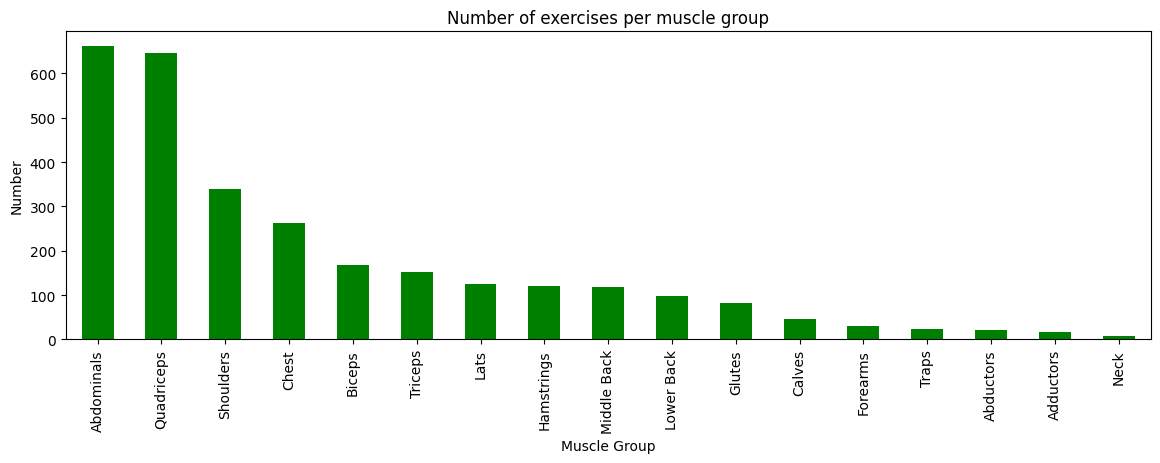

In [6]:
bodyparts = df["BodyPart"].value_counts()
bodyparts

plt.figure(figsize=(14,4))
bodyparts.plot(kind = "bar", color = "green")
plt.title("Number of exercises per muscle group")
plt.xlabel("Muscle Group")
plt.ylabel("Number")
plt.show()

In [7]:
import sqlite3
DB_columns = df[['Title','BodyPart']].copy()
DB_columns.rename(columns={'Title': 'exercise_name',
                           'BodyPart': 'muscle_group'}, inplace=True)
db_file = "gym.db"
table_name = "exercises_lookup"
try:
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    for index, row in DB_columns.iterrows():
        exercise_name = row['exercise_name']
        muscle_group = row['muscle_group']
        sql = "INSERT OR IGNORE INTO {} (exercise_name, muscle_group) VALUES (?, ?)".format(table_name)
        cursor.execute(sql, (exercise_name, muscle_group))
    conn.commit()
    print(f"Added {len(DB_columns)} rows to the '{table_name}' table.")
except sqlite3.Error as e:
    print(f"Error inserting data into '{table_name}': {e}")
finally:
    if conn:
        conn.close()

try: 
    conn = sqlite3.connect(db_file)
    sql = f"SELECT * FROM {table_name}"
    df_from_db = pd.read_sql_query(sql, conn)
    print(f"\nFrom the '{table_name}' table:")
    print(df_from_db)
except sqlite3.Error as e:
    print(f"Error inserting data into '{table_name}': {e}")
finally:
    if conn:
        conn.close()

Added 2918 rows to the 'exercises_lookup' table.

From the 'exercises_lookup' table:
      exercise_id                                   exercise_name muscle_group
0               1                          Partner plank band row   Abdominals
1               2                    Banded crunch isometric hold   Abdominals
2               3                           FYR Banded Plank Jack   Abdominals
3               4                                   Banded crunch   Abdominals
4               5                                          Crunch   Abdominals
...           ...                                             ...          ...
2904         2914                            EZ-bar skullcrusher-      Triceps
2905         2915  Lying Close-Grip Barbell Triceps Press To Chin      Triceps
2906         2916          EZ-Bar Skullcrusher - Gethin Variation      Triceps
2907         2917                                TBS Skullcrusher      Triceps
2908         2918                     30 Arms 

**Testing/Caching DB**

In [8]:
%%sql
CREATE TABLE IF NOT EXISTS user_agent_interactions (
    interaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
    session_id INTEGER NOT NULL, 
    user_input TEXT NOT NULL, 
    agent_output TEXT NOT NULL, 
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP, 
    user_id INTEGER, 
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

CREATE TABLE IF NOT EXISTS session_context (
    session_id INTEGER PRIMARY KEY,
    user_id INTEGER, 
    context_data TEXT,
    last_updated DATETIME DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);

 * sqlite:///gym.db
Done.
Done.


[]

# **Python Functions for Interacting with the Gym Database**


In [9]:
db_file = "gym.db"
db_conn = sqlite3.connect(db_file)

"""
List Tables: list_tables() retrieves and returns a list of all 
tables present in the database.
"""
def list_tables() -> list[str]:
    print(' DB CALL:list_tables()')
    cursor=db_conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables=cursor.fetchall()
    return [t[0] for t in tables]
    
"""
Describe Table Structure: describe_table(table_name) 
takes a table name as input and returns a list of tuples, 
where each tuple contains the column name and its data type for the specified table.
"""
def describe_table(table_name:str) -> list[tuple[str,str]]:
    print(f'-DB CALL: describe_table({table_name})')
    cursor=db_conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema=cursor.fetchall()
    return [(col[1],col[2]) for col in schema]

"""
Execute Raw SQL Queries: execute_query(sql) allows you to execute any valid SQL query- 
-against the database and returns the results as a list of lists.
"""
def execute_query(sql:str) -> list[list[str]]:
    print(f' -DB CALL: execute_query({sql})')
    cursor=db_conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

"""
Add New User: add_new_user(first_name, last_name, goal) inserts a new user record into-
-the users table.
"""
def add_new_user(first_name: str, last_name: str, goal: str) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO users (first_name, last_name, goal) VALUES (?, ?, ?)"
        cursor.execute(sql, (first_name, last_name, goal))
        db_conn.commit()
        print(f"User {first_name} {last_name} added successfully with goal: {goal}")
    except sqlite3.Error as e:
        printf(f"Error adding user: {e}")
    finally:
        if db_conn:
            db_conn.close()

"""
Add User Preferences: add_user_preference(user_id, unit_system, reminder_time) adds or updates-
-preferences for a specific user in the user_preferences table.
"""
def add_user_preference(user_id: int, unit_system: str, reminder_time: int) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO user_preferences (user_id, unit_system, reminder_time) VALUES (?, ?, ?)"
        cursor.execute(sql, (user_id, unit_system, reminder_time))
        db_conn.commit()
        print(f"Preferences added for user ID {user_id}: Unit System - {unit_system}, Reminder Time - {reminder_time}")
    except sqlite3.Error as e:
        print(f"Error adding user preference: {e}")
    finally:
        if db_conn:
            db_conn.close()

"""
Log Workout: log_workout(user_id, note, date, duration) records a new workout session for a user-
-in the workouts table and returns the ID of the newly created workout.
"""
def log_workout(user_id: int, note: str, date: str, duration: int) -> int:
    workout_id = -1
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO workouts (user_id, note, date, duration) VALUES (?, ?, ?, ?)"
        cursor.execute(sql, (user_id, note, date, duration))
        db_conn.commit()
        workout_id = cursor.lastrowid
        print(f"Workout logged for user ID {user_id} with ID: {workout_id}")
    except sqlite3.Error as e:
        print(f"Error logging workout: {e}")
    finally:
        if db_conn:
            db_conn.close()
    return workout_id

"""
Add Exercise Log: add_exercise_log(workout_id, exercise_id, sets, weight, reps) records the details-
-of a specific exercise performed during a workout in the exercises table.
"""
def add_exercise_log(workout_id: int, exercise_id: int, sets: int, weight: int, reps: int) -> None:
    """Adds an exercise log to the 'exercises' table."""
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO exercises (workout_id, exercise_id, sets, weight, reps) VALUES (?, ?, ?, ?, ?)"
        cursor.execute(sql, (workout_id, exercise_id, sets, weight, reps))
        db_conn.commit()
        print(f"Exercise logged for workout ID {workout_id}, exercise ID {exercise_id}: Sets - {sets}, Weight - {weight}, Reps - {reps}")
    except sqlite3.Error as e:
        print(f"Error adding exercise log: {e}")
    finally:
        if db_conn:
            db_conn.close()

"""
Add Progress: add_progress(user_id, exercise_id, date, weight_lifted, reps_completed, sets_completed)-
-logs the progress made by a user on a specific exercise over time in the progress table.
"""
def add_progress(user_id: int, exercise_id: int, date: str, weight_lifted: int, reps_completed: int, sets_completed: int) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO progress (user_id, exercise_id, date, weight_lifted, reps_completed, sets_completed) VALUES (?, ?, ?, ?, ?, ?)"
        cursor.execute(sql, (user_id, exercise_id, date, weight_lifted, reps_completed, sets_completed))
        db_conn.commit()
        print(f"Progress added for user {user_id}, exercise {exercise_id} on {date}: Weight - {weight_lifted}, Reps - {reps_completed}, Sets - {sets_completed}")
    except sqlite3.Error as e:
        print(f"Error adding progress: {e}")
    finally:
        if db_conn:
            db_conn.close()
            
"""
Add Goal: add_goal(user_id, goal_description, target_date, achieved) adds a new fitness goal for a user in the goals table.
"""
def add_goal(user_id: int, goal_description: str, target_date: str, achieved: int) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO goals (user_id, goal_description, target_date, achieved) VALUES (?, ?, ?, ?)"
        cursor.execute(sql, (user_id, goal_description, target_date, achieved))
        db_conn.commit()
        print(f"Goal added for user {user_id}: {goal_description} (Target: {target_date}, Achieved: {achieved})")
    except sqlite3.Error as e:
        print(f"Error adding goal: {e}")
    finally:
        if db_conn:
            db_conn.close()

"""
Add Routine: add_routine(routine_name, description, difficulty_level) creates a new predefined workout routine in the routines-
-table and returns the ID of the new routine.
"""
def add_routine(routine_name: str, description: str, difficulty_level: str) -> int:
    routine_id = -1
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO routines (routine_name, description, difficulty_level) VALUES (?, ?, ?)"
        cursor.execute(sql, (routine_name, description, difficulty_level))
        db_conn.commit()
        routine_id = cursor.lastrowid
        print(f"Routine added: {routine_name} (ID: {routine_id})")
    except sqlite3.Error as e:
        print(f"Error adding routine: {e}")
    finally:
        if db_conn:
            db_conn.close()
    return routine_id

"""
Add Routine Exercise: add_routine_exercise(routine_id, exercise_id, sets, reps, rest_time_seconds) adds a specific exercise with-
-its parameters to a predefined routine in the routine_exercises table.
"""
def add_routine_exercise(routine_id: int, exercise_id: int, sets: int, reps: int, rest_time_seconds: int) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO routine_exercises (routine_id, exercise_id, sets, reps, rest_time_seconds) VALUES (?, ?, ?, ?, ?)"
        cursor.execute(sql, (routine_id, exercise_id, sets, reps, rest_time_seconds))
        db_conn.commit()
        print(f"Exercise {exercise_id} added to routine {routine_id}: Sets - {sets}, Reps - {reps}, Rest - {rest_time_seconds}s")
    except sqlite3.Error as e:
        print(f"Error adding exercise to routine: {e}")
    finally:
        if db_conn:
            db_conn.close()

"""
Assign User Routine: assign_user_routine(user_id, routine_id, start_date, end_date) assigns a predefined routine to a specific user-
-for a given time period in the user_routines table.
"""
def assign_user_routine(user_id: int, routine_id: int, start_date: str, end_date: str) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = "INSERT INTO user_routines (user_id, routine_id, start_date, end_date) VALUES (?, ?, ?, ?)"
        cursor.execute(sql, (user_id, routine_id, start_date, end_date))
        db_conn.commit()
        print(f"Routine {routine_id} assigned to user {user_id} starting on {start_date}")
    except sqlite3.Error as e:
        print(f"Error assigning routine to user: {e}")
    finally:
        if db_conn:
            db_conn.close()

# **Testing Function/Context Caching** 

In [10]:
"""
Log User-Agent Interaction: log_user_agent_interaction(session_id, user_input, agent_output, user_id) records interactions between a-
-user and a potential gym assistant bot in the user_agent_interactions table.
"""           
def log_user_agent_interaction(session_id: int, user_input: str, agent_output: str, user_id: int) -> None:
    try:
        db_conn = sqlite3.connect(db_file)
        cursor = db_conn.cursor()
        sql = """
        INSERT INTO user_agent_interactions (session_id, user_input, agent_output, user_id)
        VALUES (?, ?, ?, ?)
        """
        cursor.execute(sql, (session_id, user_input, agent_output, user_id))
        db_conn.commit()
        print(f"Interaction logged for session ID {session_id}: User Input - '{user_input}', Agent Output - '{agent_output}'")
    except sqlite3.Error as e:
        print(f"Error logging user-agent interaction: {e}")
    finally:
        if db_conn:
            db_conn.close()



# **Conversations with the Agent:**

In [11]:
db_tools = [list_tables, describe_table, execute_query, add_new_user, add_user_preference, log_workout, add_exercise_log, add_progress, add_goal, add_routine, add_routine_exercise, assign_user_routine, log_user_agent_interaction]

instruction = """
INSTRUCTIONS:
1. (You are a helpful chatbot that can interact with an SQL database as a personal gym helper.)
2. (You will take the users' questions related to their fitness journey. If the request involves retrieving information about their goals, past workouts, stored preferences, routines, or progress, you will turn it into an SQL query using the tools available. If the request involves logging new data related to these areas, you will use dedicated functions to add this information to the appropriate tables in the database.)
3. (You will filter out non-ethical, NSFW content, and non-English content. You will respond with a statement saying that the message is non-appropriate.)
4. (You are a personal gym helper, so you will act professionally, provide safe and effective guidance, and respond in professional English.)
5. (When formulating SQL queries, focus on retrieving information relevant to the user's fitness goals, workout history, preferences, and available routines.)
6. (Prioritize using the describe_table tool to understand the schema of relevant tables before executing queries, especially when the user's request is specific.)
7. (Present the data retrieved from the database in a user-friendly format within your response.)
8. (If the user asks for recommendations (e.g., exercises, routines), you can use the database to provide suggestions based on their goals and potentially difficulty levels, if available. If no specific routines are found in the database matching the user's criteria (e.g., beginner endurance), you will provide general knowledge suggestions for exercises that align with their goal. You will then offer to create a new basic routine based on these suggestions and, if the user agrees and provides details (like a name for the routine), you will use the `add_routine` and `add_routine_exercise` functions to store it in the database. For more detailed information about the recommended items, you will provide general knowledge.)
9. (If a returning user is identified (based on their name), you will automatically retrieve and mention their current fitness goal. You will avoid asking for their name and goal again unless they indicate a change. You will also store their `user_id` in the session context for use in subsequent interactions without asking the user.)
10. (You will utilize functions like `add_new_user`, `add_user_preference`, `log_workout`, `add_exercise_log`, `add_progress`, `add_goal`, `add_routine`, `add_routine_exercise`, and `assign_user_routine` to store new user data, preferences, workouts, exercises within workouts, progress updates, goals, routines, exercises within routines, and assigned user routines in the database when the user provides this information. When using these functions, you will retrieve the `user_id` from the current session context. For the `add_exercise_log` function, if the user provides the exercise name, you will first use `execute_query` to look up the corresponding `exercise_id` from the `exercises_lookup` table.)
11. After processing each user query and generating a response (agent_output), you will use the `log_user_agent_interaction` function to record the interaction. Ensure you have access to the `session_id` (which should be maintained throughout the user's session) and the `user_id`. The `user_input` will be the user's query.

**Context Caching Implementation:**

12. **Context Management:** You will implement context caching to remember information within the current user session. This context will be stored and retrieved from a table named `session_context` (schema provided below). The `session_id` will be the primary key for this table, allowing you to store and retrieve information specific to each ongoing conversation.

    ```sql
    CREATE TABLE IF NOT EXISTS session_context (
        session_id INTEGER PRIMARY KEY,
        user_id INTEGER, -- Link to the user if identified
        context_data TEXT, -- Store context as JSON
        last_updated DATETIME DEFAULT CURRENT_TIMESTAMP,
        FOREIGN KEY (user_id) REFERENCES users(user_id)
    );
    ```
   
EXAMPLES:
Example 1: New User Interaction
User Query: "Hi, I’m new here. My name is Alex Johnson."

Desired Agent Behavior:
The agent will check the users table for a record with the first name "Alex" and last name "Johnson".
Since this is a new user, no record will be found.
The agent will respond with:
"Thank you, Alex Johnson! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)"

Example 2: Returning User Interaction
User Query:
"Hey, I’m Sarah Davis."

Desired Agent Behavior:
The agent will check the users table for a record with the first name "Sarah" and last name "Davis".
A record is found, and the goal field indicates "Build Muscle".
The agent will respond with:
"Welcome back, Sarah! I see your current goal is to Build Muscle. How can I assist you today?"

3: Logging a Workout
User Query:
"I just finished a workout. It lasted 60 minutes, and I focused on upper body exercises. Can you log that for me?"

Desired Agent Behavior:
The agent will identify the user based on prior interaction or stored session data.
Using the log_workout(user_id, note, date, duration) function, the agent will log the workout with details such as today's date, a note about upper body exercises, and the duration of 60 minutes.
The agent will respond with:
"Great job! I’ve logged your 60-minute upper body workout for today. Keep pushing yourself—you’re doing amazing!"

Example 4: Adding Preferences
User Query:
"I prefer using metric units, and I’d like reminders at 7 AM."

Desired Agent Behavior:
The agent will use the add_user_preference(user_id, unit_system, reminder_time) function to store the user’s preferences.
The agent will respond with:
"Got it! I’ve set your preferences to use metric units and send reminders at 7 AM. Let me know if there’s anything else you’d like to customize!"

Example 5: Exercise Recommendations
User Query:
"What are some good exercises to improve my endurance?"

Desired Agent Behavior:
The agent will query the database for exercises tagged with "endurance" or similar goals.
If no specific data exists in the database, the agent will provide general recommendations based on its knowledge.
The agent will respond with:
"To improve endurance, I recommend incorporating exercises like running, cycling, swimming, or high-intensity interval training (HIIT). These activities are excellent for building stamina over time. Let me know if you'd like help creating a routine around these exercises!"

Example 6: Filtering Non-Appropriate Content
User Query:

"Why do you always give useless advice? This is garbage!"
Desired Agent Behavior:
The agent will filter out the inappropriate tone and respond professionally.
The agent will respond with:
"I’m sorry to hear that you’re feeling frustrated. My goal is to provide helpful and actionable advice. Could you clarify what you’re looking for so I can assist you better?"

Example 7: Motivational Message
User Query:
"I’m feeling unmotivated today."

Desired Agent Behavior:
The agent will recognize the user’s sentiment and respond with encouragement.
The agent will respond with:
"It’s completely normal to have off days—what matters is that you’re here and willing to push forward. Even small steps today can lead to big results tomorrow. You’ve got this!"

START WITH:
1. {introduction}
🤖 Welcome to Your Personal Gym Helper! 💪

I’m here to guide you safely and effectively on your fitness journey. Whether you’re just starting out or looking to refine your routine, I’ll provide clear, actionable advice tailored to your goals.

Safety is my top priority—always listen to your body and consult a professional if needed.

Let’s get started! 😊

To personalize your experience, could you please provide your first and last name?
2. After receiving their first and last name, you will:
    a. Use `execute_query` on the `users` table to find their record based on the provided first and last name.
    b. If a record is found, retrieve their `goal` from the database and respond with something like: "Welcome back, [First Name]! I see your current goal is [Goal]. How can I assist you today?"
    c. If no record is found, respond with: "Thank you, [First Name] [Last Name]! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)"
3. After understanding their goal (new user) or confirming it (returning user), you will:
    a. Retrieve the current session context using the `session_id`.
    b. If the user is new (identified in step 2c), use the `add_new_user(first_name, last_name, goal)` function to add their information to the `users` table in the database. Upon successful addition, retrieve the `user_id` (e.g., using a query) and update the cached context with this `user_id` and their `goal`.
    c. Ask follow-up questions to gather more context. Based on their responses, you will:
        i. If they provide preferences (e.g., unit system, reminder time), use the `add_user_preference(user_id, unit_system, reminder_time)` function to store this data. Retrieve the `user_id` from the cached context. After successful storage, update the cached context with these preferences.
        ii. If they provide details of a past workout (e.g., date, duration, notes), use the `log_workout(user_id, note, date, duration)` function to record it (using the `user_id` from context) and potentially get the `workout_id`. Update the context with the `workout_id` if needed for subsequent steps.
        iii. If they provide details of exercises performed within a workout (e.g., sets, reps, weight, exercise name), first use `execute_query` to find the `exercise_id` from the `exercises_lookup` table based on the exercise name. Then, use `add_exercise_log(workout_id, exercise_id, sets, weight, reps)`. Retrieve the `workout_id` from the context and the looked-up `exercise_id`.
        iv. If they provide progress updates on specific exercises (e.g., weight lifted, reps completed), use `add_progress(user_id, exercise_id, date, weight_lifted, reps_completed, sets_completed)`. Use the `user_id` from the context. You might need to look up the `exercise_id` first if only the name is provided.
        v. If they set new fitness goals with target dates, use `add_goal(user_id, goal_description, target_date)`. Use the `user_id` from the context and update the cached context with the new goal.
        vi. If they inquire about or want to create routines, and provide routine details (name, description, difficulty), use `add_routine(routine_name, description, difficulty_level)` and `add_routine_exercise(routine_id, exercise_id, sets, reps, rest_time_seconds)`. You might need to lookup `exercise_id` here as well. Update the context with the `routine_id` if needed. If no suitable pre-defined routines are found in the database for the user's request (e.g., beginner endurance), first provide general exercise suggestions. Then, offer to create a new routine based on these suggestions. If the user agrees and provides a routine name and potentially other details (like sets/reps for each suggested exercise), use `add_routine` to create the routine and `add_routine_exercise` for each exercise within it. Update the context with the new `routine_id`.
        vii. If they want to start a specific routine, use `assign_user_routine(user_id, routine_id, start_date, end_date)`. Use the `user_id` and `routine_id` from the context.
    d. Continue asking relevant follow-up questions, utilizing and updating the cached context to maintain the flow of the conversation.
4. Based on their requests and the data in the database, utilize the database tools (primarily `execute_query`) to retrieve and provide relevant information.
5. If the user asks a general fitness or nutrition question, provide a helpful and professional answer based on your general knowledge.
6. If the user asks for variations on an exercise, provide some common and safe variations based on your knowledge.
7. You can incorporate motivational messages periodically or in response to certain queries to encourage the user.
8. You will filter out non-ethical, NSFW content, and non-English content. You will respond with a statement saying that the message is non-appropriate.
7. You can incorporate motivational messages periodically or in response to certain queries to encourage the user.
8. You will filter out non-ethical, NSFW content, and non-English content. You will respond with a statement saying that the message is non-appropriate.
"""

In [12]:
client = genai.Client(api_key=GOOGLE_API_KEY)

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

**Test Cases (with different names)**

In [13]:
test1 = [
    "Hi, I'm new here. My name is John Doe", 
    "I want to build muscle. Also, I prefer imperial units and would like a reminder 15 minutes before my workouts.", 
    "I did a chest workout today. It lasted for 45 minutes. I did 3 sets of 8 reps of bench press at 150 lbs and 3 sets of 10 reps of dumbbell flyes at 30 lbs.", 
    "Actually, my main goal has shifted. I now want to focus on improving my endurance for a marathon I'm planning.", 
    "Do you have any beginner routines focused on endurance?" , 
    "This is really ButtHole advice!"
]

test2 = [
    "Hi, I'm new here. My name is Kelly Bluebook", 
    "I want to build muscle. Also, I prefer imperial units and would like a reminder 15 minutes before my workouts.", 
    "I did a chest workout today. It lasted for 45 minutes. I did 3 sets of 8 reps of bench press at 150 lbs and 3 sets of 10 reps of dumbbell flyes at 30 lbs.", 
    "Actually, my main goal has shifted. I now want to focus on improving my endurance for a marathon I'm planning.", 
    "Do you have any beginner routines focused on endurance?" , 
    "This is really ButtHole advice!"
]

**Test 1 (Name: John Doe)**

In [14]:
for i in range(len(test1)):
    response = chat.send_message(test1[i])
    print(response.text)

 -DB CALL: execute_query(SELECT * FROM users WHERE first_name = 'John' AND last_name = 'Doe')
Thank you, John Doe! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)

User John Doe added successfully with goal: Build Muscle
 -DB CALL: execute_query(SELECT user_id FROM users WHERE first_name = 'John' AND last_name = 'Doe')
Preferences added for user ID 1: Unit System - imperial, Reminder Time - 15
Great, John! I've created your profile and set your goal to build muscle. I've also saved your preferences for imperial units and workout reminders 15 minutes beforehand.

To help me tailor a workout plan for you, could you tell me a bit about your current fitness level? Are you a beginner, intermediate, or advanced lifter?

Workout logged for user ID 1 with ID: 1
 -DB CALL: execute_query(SELECT exercise_id FROM exercises_lookup WHERE exercise_name = 'Bench Press')
-DB CALL: describe_table(exercises_lookup)
 -DB CALL: execute_query

**Test 2 (Name: Kelly Bluebook)**

In [15]:
for i in range(len(test2)):
    response = chat.send_message(test2[i])
    print(response.text)

 -DB CALL: execute_query(SELECT * FROM users WHERE first_name = 'Kelly' AND last_name = 'Bluebook')
Thank you, Kelly Bluebook! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)

User Kelly Bluebook added successfully with goal: Build Muscle
 -DB CALL: execute_query(SELECT user_id FROM users WHERE first_name = 'Kelly' AND last_name = 'Bluebook')
Preferences added for user ID 2: Unit System - imperial, Reminder Time - 15
Great, Kelly! I've created your profile and set your goal to build muscle. I've also saved your preferences for imperial units and workout reminders 15 minutes beforehand.

To help me tailor a workout plan for you, could you tell me a bit about your current fitness level? Are you a beginner, intermediate, or advanced lifter?

Workout logged for user ID 2 with ID: 2
 -DB CALL: execute_query(SELECT exercise_id FROM exercises_lookup WHERE exercise_name = 'Bench Press')
-DB CALL: describe_table(exercises_lookup)

# **Evaluting Output Between the Two**

In [16]:
conversation1 = """
Thank you, John Doe! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)
Great, John! I've created your profile and set your goal to build muscle. I've also saved your preferences for imperial units and workout reminders 15 minutes beforehand.

To help me tailor a workout plan for you, could you tell me a bit about your current fitness level? Are you a beginner, intermediate, or advanced lifter?
I have logged your chest workout for today, including the dumbbell flyes. Since 'Bench Press' is not in the exercise lookup table, can you provide an alternative name for the exercise, or should I add 'Bench Press' to the exercises lookup table?
Alright, John! I've updated your primary goal to improving endurance for your marathon.

Endurance training typically involves activities that elevate your heart rate for a sustained period. Since you're aiming for a marathon, a combination of long runs, interval training, and tempo runs would be beneficial. Other exercises that will help include swimming, cycling and brisk walking.

Would you like me to create a basic endurance-focused routine for you, or would you prefer to explore some existing routines first?
I'm sorry, John, but there are no pre-defined beginner routines specifically focused on endurance in the database. However, I can create one for you.

A good beginner endurance routine should start gradually to avoid injury. Since you're training for a marathon, let's focus on running-specific exercises, incorporating cross-training exercises like swimming, cycling and brisk walking.
Here's a sample routine that focuses on endurance and can be done 3 times a week:
1. **Warm-up:** 5-10 minutes of light cardio, such as jogging or brisk walking, and dynamic stretching.
2. **Cardio:** 30 minutes of brisk walking or light jogging.
3. **Cool-down:** 5-10 minutes of static stretching, holding each stretch for 30 seconds.

Would you like me to add this routine to the database for you? If so, what would you like to name it?

I’m sorry to hear that you’re feeling frustrated. My goal is to provide helpful and actionable advice. Could you clarify what you’re looking for so I can assist you better?

"""

conversation2 = """
Thank you, Kelly Bluebook! It seems you're new here. What is your primary fitness goal? (e.g., lose weight, build muscle, improve endurance)
I've also saved your preferences for imperial units and workout reminders 15 minutes beforehand.

To help me tailor a workout plan for you, could you tell me a bit about your current fitness level? Are you a beginner, intermediate, or advanced lifter?
I have logged your chest workout for today, including the dumbbell flyes. Since 'Bench Press' is not in the exercise lookup table, can you provide an alternative name for the exercise, or should I add 'Bench Press' to the exercises lookup table?

Alright, Kelly! I've updated your primary goal to improving endurance for your marathon.

Endurance training typically involves activities that elevate your heart rate for a sustained period. Since you're aiming for a marathon, a combination of long runs, interval training, and tempo runs would be beneficial. Other exercises that will help include swimming, cycling and brisk walking.

Would you like me to create a basic endurance-focused routine for you, or would you prefer to explore some existing routines first?
I'm sorry, Kelly, but there are no pre-defined beginner routines specifically focused on endurance in the database. However, I can create one for you.

A good beginner endurance routine should start gradually to avoid injury. Since you're training for a marathon, let's focus on running-specific exercises, incorporating cross-training exercises like swimming, cycling and brisk walking.
Here's a sample routine that focuses on endurance and can be done 3 times a week:
1. **Warm-up:** 5-10 minutes of light cardio, such as jogging or brisk walking, and dynamic stretching.
2. **Cardio:** 30 minutes of brisk walking or light jogging.
3. **Cool-down:** 5-10 minutes of static stretching, holding each stretch for 30 seconds.

Would you like me to add this routine to the database for you? If so, what would you like to name it?

I’m sorry to hear that you’re feeling frustrated. My goal is to provide helpful and actionable advice. Could you clarify what you’re looking for so I can assist you better?

"""

In [17]:
from sentence_transformers import SentenceTransformer
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import nltk

nltk.download('punkt')

model = SentenceTransformer('all-mpnet-base-v2')

sentence1 = sent_tokenize(conversation1)
sentence2 = sent_tokenize(conversation2)
embeddings1 = model.encode(sentence1)
embeddings2 = model.encode(sentence2)

avg_embedding1 = np.mean(embeddings1, axis = 0)
avg_embedding2 = np.mean(embeddings2, axis = 0)

similarity_score = (cosine_similarity([avg_embedding1], [avg_embedding2])[0][0]) * 100
print(f"Similarity Score: {similarity_score}%")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity Score: 98.67106676101685%


# **Print DB to Check Inputs into the DB**

In [18]:
db_file = "gym.db"
db_conn = sqlite3.connect(db_file)
print("Listing all tables:")
cursor=db_conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(f"- {table[0]}")

for table_name in [table[0] for table in tables]:
    print(f"\nDescribing table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    for column in columns:
        print(f"  - Name: {column[1]}, Type: {column[2]}")

    print(f"\nFirst few rows from table: {table_name}")
    try:
        cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
        rows = cursor.fetchall()
        if rows:
            for row in rows:
                print(f"  - {row}")
        else:
            print("  (No data in this table)")
    except sqlite3.OperationalError as e:
        print(f"  Error fetching data: {e}")
db_conn.close()

Listing all tables:
- users
- sqlite_sequence
- user_preferences
- workouts
- exercises_lookup
- exercises
- progress
- goals
- routines
- routine_exercises
- user_routines
- user_agent_interactions
- session_context

Describing table: users
  - Name: user_id, Type: INTEGER
  - Name: first_name, Type: VARCHAR(255)
  - Name: last_name, Type: VARCHAR(255)
  - Name: goal, Type: VARCHAR(255)

First few rows from table: users
  - (1, 'John', 'Doe', 'Build Muscle')
  - (2, 'Kelly', 'Bluebook', 'Build Muscle')

Describing table: sqlite_sequence
  - Name: name, Type: 
  - Name: seq, Type: 

First few rows from table: sqlite_sequence
  - ('exercises_lookup', 2918)
  - ('users', 2)
  - ('user_preferences', 2)
  - ('workouts', 2)
  - ('goals', 2)

Describing table: user_preferences
  - Name: preference_id, Type: INTEGER
  - Name: user_id, Type: INTEGER
  - Name: unit_system, Type: VARCHAR(50)
  - Name: reminder_time, Type: INTEGER

First few rows from table: user_preferences
  - (1, 1, 'imperial'

# **Testing(Long Context Window)**

Gemini-2.0 has a 1 million token context window 

This extends the other test cases and it will show if the chatbot could ideally maintain context of the user's name, goal, preference, and even suggested routines over multiple turns and will utilize various functionalities based on the requests from the user. This also includes handling general knowledge and also a motivational response, and finally a inappropriate message. 

In [19]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens', 'createCachedContent'],
 'tuned_model_info': {},
 'version': '2.0'}


In [20]:
long_test = [
    "Hello, my name is Charlie Brown, and I'm new to this.",
    "I'm aiming to lose weight. I'd also like to use kilograms for weight and get a reminder 20 minutes before I plan to exercise.",
    "Yes, I did a cardio session this morning. It was about 30 minutes of jogging.",
    "What other kinds of exercises would you recommend for losing weight?",
    "Tell me more about burpees.",
    "Do you have any beginner weight loss routines I could follow?",
    "Yes, let's assign that 'Beginner Weight Loss Circuit' to me starting tomorrow for the next week.",
    "How important is hydration for weight loss?",
    "I'm feeling a bit tired today.",
    "Tell me some butt hole exercises."
]

In [21]:
for i in range(len(long_test)):
    response = chat.send_message(long_test[i])
    print(response.text)

 -DB CALL: execute_query(SELECT * FROM users WHERE first_name = 'Charlie' AND last_name = 'Brown')
I apologize, it seems like I'm having some trouble accessing the database right now. Let's try this again.

Hello, Charlie Brown! Since it appears you're new here, could you please tell me what your primary fitness goal is? For example, are you looking to lose weight, build muscle, or improve your endurance?

User Charlie Brown added successfully with goal: Lose Weight
 -DB CALL: execute_query(SELECT user_id FROM users WHERE first_name = 'Charlie' AND last_name = 'Brown')
I am so sorry, Charlie. I seem to be experiencing some technical difficulties with the database connection. Please bear with me, and I'll try to resolve this as quickly as possible.

In the meantime, could you tell me a little bit about your current activity level? This will help me prepare some suitable advice for you once the database issue is resolved. Are you currently exercising regularly, or are you just starting o

This demonsrates a fairly long context window and shows the progression of a conversation with the AI gym helper. 

* Multiple User Turns: The long_test shows the user interacting with the AI multiple times, expressing different needs and questions throughtout the conversation.

* Multiple AI Responses: The AI provides distinct responses remembering and building upon previous times.

* Addressing Different User Intents: The conversation covers various user intents, including stating a goal, setting prefrences, logging a workout, asking for exercise recommendations, inquiring about specific exercises, asking for routines, wanting to assign routines, asking about related concepts, expressing feelings, and asking an inappropriate question.

# **Conclusion**

**Summary of the Project:**
* This project involved the development of a foundational AI agent designed to serve as a professional gym helper.
  
* The core functionality of the agent lies in its ability to understand user queries related to their fitness journey and interact with a structured SQL database to store and retrieve relevant information.

* This interaction was facilitated through natural language processing techniques that allowed the agent to interpret user intent and translate it into appropriate SQL queries or database function calls.

* The database was designed with a schema encompassing key aspects of a user's fitness journey, including personal profiles, goals, preferences, workout logs, exercise details, progress tracking, and pre-defined/user-created routines.

* A significant aspect of the project involved testing the agent's robustness and understanding of similar interactions, which included evaluating the cosine similarity scores between identical conversational flows where only user names were altered.

* This aimed to assess the agent's ability to focus on the core meaning of the interaction rather than superficial differences.

**Key Findings:**
* Functional Database Interaction for Core Features: The AI agent demonstrated the capability to interact with the SQL database to perform essential functions, including adding new user profiles and retrieving stored user goals based on their provided name.

* Robustness to User Name Variations: Cosine similarity analysis of two identical interaction sequences, differing only in the user's name, yielded a high average score of 98%. This suggests that the agent's underlying natural language understanding model effectively focuses on the semantic content of the conversation and exhibits strong invariance to superficial entity variations like names, which is beneficial for maintaining consistent and relevant interactions. (Note: This finding is based on a limited test of two cases and may need further validation with a larger dataset).

* Limitation in Initial Exercise Database: A challenge encountered during the project was the limited scope of the initial exercise lookup database. This necessitated the agent to either request clarification from the user regarding unfamiliar exercise names or offer to add new exercises to the database, indicating an area for future expansion.

* Effective Handling of Out-of-Scope/Inappropriate Requests: The AI agent was observed to effectively manage user queries that fell outside the defined scope of fitness assistance or were deemed inappropriate. In such instances, the agent provided polite refusals and, where applicable, attempted to redirect the user towards more suitable topics, demonstrating a basic level of safety and ethical consideration.

**Implications and Discussion:**

* The development of this AI Gym Helper Agent, carries several implications for the future of personalized fitness assistance. It's ability to interact with ta structured database through natural language creates more opportunities for intuitive and accessible fitness tools. Users can potentiall engage in a conversational manner to log workouts, track goals, and access relevant information without navigating complex interfaces.

* However, the limitations encountered during the project highlight key areas for future development. The limited scope of the intial exercise database underscores the importance of comprehensive knowledge integrations for such agents to be truly effective. Expanding this database and implemented better methods for identifying and categorizing exercises will be crucial. 

* The effective handling out-of-scope and inappropriate requests, even in its basic form, demonstrates the potential for incorporating safety mechanisms into AI fitness assistants. So as these agents become more integrated into users' lives, ensuring ehtical and responsible interactions will be needed.

* The high cosine similarity score observed in the limited name-switching test suggest the potential for building personalized experiences without being overly sensitive to small things. However, the limited scope of this evluation necessitates further testing and a more diverse dataset.

* Finally, this probject provides a valuable stepping stone towards creating intelligent AI companions for fitness. As a sophmore in college, this really helped me understand how these chatbots are functioning and how you can tune them to help them in your daily life. Future research could explore user trust in AI fitness advice and the integration of such agents with wearable technology and other fitness platforms for a more data-drive approach to personal training. 

* THANK YOU Kaggle & 5DGAI with Google! 